In [1]:
import random
import numpy as np
import chainer
from chainer.backends import cuda
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

from chainer.datasets import split_dataset_random

## Load MNIST dataset

In [2]:
from chainer.datasets import mnist

train_valid, test = mnist.get_mnist()

In [3]:
print("train_valid: %s" % type(train_valid))
print("test: %s" % type(test))

print("# of train_valid: %s" % len(train_valid))
print("# of test: %s" % len(test))

train_valid: <class 'chainer.datasets.tuple_dataset.TupleDataset'>
test: <class 'chainer.datasets.tuple_dataset.TupleDataset'>
# of train_valid: 60000
# of test: 10000


### Split the dataset

In [4]:
train, valid = split_dataset_random(train_valid, 50000, seed = 0)

In [5]:
print("# of training dataset: ",  len(train))
print("# of validation dataset: ", len(valid))
print("# of test dataset: ", len(test))

# of training dataset:  50000
# of validation dataset:  10000
# of test dataset:  10000


## Prepare iterators

In [6]:
batch_size = 128

train_iter = iterators.SerialIterator(train, batch_size)
valid_iter = iterators.SerialIterator(valid, batch_size, repeat=False, shuffle=False)
test_iter  = iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

## Build the model

In [7]:
class LeNet5LikeConvNet(Chain):
    def __init__(self):
        super(LeNet5LikeConvNet, self).__init__()
        
        with self.init_scope():
            self.c1 = L.Convolution2D(1, 6, ksize=5, stride=1, pad=2)  # same padding      
            self.c3 = L.Convolution2D(6, 16, ksize=5, stride=1)
            self.c5 = L.Convolution2D(16, 120, ksize=5, stride=1)
            self.f6  = L.Linear(None, 84)
            self.out = L.Linear(84, 10)
    
    def __call__(self, x):
        X = F.reshape(x, (-1, 1, 28, 28))

        a1 = F.tanh(self.c1(X))                                # shape: (m, 6, 28, 28)
        a2 = F.max_pooling_2d(a1, 2, stride=2)  # shape: (m, 6, 14, 14)
        a3 = F.tanh(self.c3(a2))                              # shape: (m, 16, 10, 10)
        a4 = F.max_pooling_2d(a3, 2, stride=2)  # shape: (m, 16, 5, 5)
        a5 = F.tanh(self.c5(a4))                              # shape: (m, 120, 1, 1)
        a6 = F.tanh(self.f6(a5))                              # shape: (m, 84)
        out =self.out(a6)                                         # shape: (m, 10) 
        
        if chainer.config.train:
            return out

        return F.softmax(out)

In [8]:
x0, y0 = train[0]
model = LeNet5LikeConvNet()
print(type(model(x0)))

print(model(x0).shape)
print(model(x0))

<class 'chainer.variable.Variable'>
(1, 10)
variable([[ 0.20442472  0.02512133 -0.51674044 -0.19569725  0.3151341
            0.057723    0.17618088 -0.09279872  0.23288204  0.01059669]])


## Train the model

In [9]:
def create_trainer(model,  train_iter, valid_iter, max_epoch=10, gpu_id = -1):
    if gpu_id >= 0:
        model.to_gpu(gpu_id)

    optimizer = optimizers.Adam()
    optimizer.setup(model)
    
    updater = training.updater.StandardUpdater(train_iter, optimizer, device=gpu_id)

    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='out/mnist')
    
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
    trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
    trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.extend(extensions.dump_graph('main/loss'))
    
    return trainer

In [10]:
def reset_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)

reset_seed(0)

In [11]:
net = LeNet5LikeConvNet()
model = L.Classifier(net)

train_iter.reset()
valid_iter.reset()

trainer = create_trainer(model, train_iter, valid_iter, max_epoch=10)
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.290691    0.918978       1.51249               0.969442                  59.2987       
2           0.0800085   0.975963       1.49165               0.980617                  126.013       
3           0.0551037   0.983173       1.4858                0.984177                  184.098       
4           0.0420847   0.987552       1.48367               0.984672                  242.801       
5           0.0339842   0.98981        1.47957               0.987243                  300.647       
6           0.0268326   0.991747       1.47875               0.986551                  359.178       
7           0.0218041   0.993067       1.47699               0.988133                  417.147       
8           0.0178369   0.994651       1.47675               0.987243                  476.947       
9           0.014369    0.995624       1.47596               0.987836               

## Evaluate the model with test set

In [12]:
gpu_id = -1

test_iter.reset()
test_evaluator = extensions.Evaluator(test_iter, model, device=gpu_id)
results = test_evaluator()
print('Test accuracy:', results['main/accuracy'])

Test accuracy: 0.9887262658227848


## Inference

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

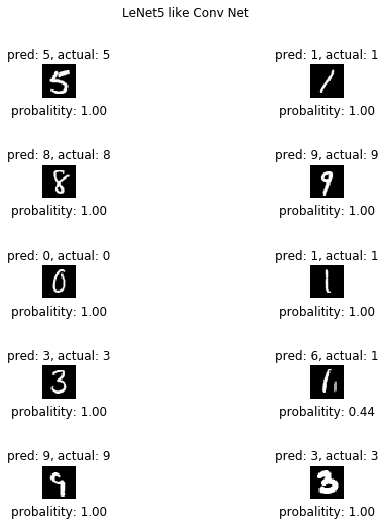

In [14]:
infer_net = LeNet5LikeConvNet()
serializers.load_npz(
    'out/mnist/snapshot_epoch-10',
    infer_net, path='updater/model:main/predictor/')


# figure
fig, axes = plt.subplots(5, 2, figsize=(8, 8))
title = 'LeNet5 like Conv Net'
fig.suptitle(title, fontsize=12)


with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    for idx, randint in enumerate(np.random.randint(0, len(test), size = 10)):
        test_x, test_label = test[randint]

        pred = infer_net(test_x).data
        pred_val = np.round(pred.max(axis=None), decimals=3)
        pred_label = pred.argmax(axis=None)
                
        row = int(idx / 2)
        fig.subplots_adjust(wspace=0.5, hspace=2.0)
        ax = axes[row, idx % 2]
        ax.axis('off')
        ax.set_title("pred: {}, actual: {}".format(pred_label, test_label))
        ax.text(0.5, -0.5, "probalitity: {:.2f}".format(pred_val), size=12, ha="center", transform=ax.transAxes)
        ax.imshow(test_x.reshape(28, 28), cmap='gray')